In [69]:
import numpy as np
import pandas as pd
import seaborn as sns
import json
import pprint
from datetime import datetime
import requests

In [70]:
#Helper functions

#Conversion from kBTU (Current unit) to kWH (Metric System)
def convert_kwh(kbtu_unit):
    return kbtu_unit * 0.29307106944 

#Conversion of dates into datetime objects
def convert_dates(dates):
    return [datetime.strptime(d,"%Y-%m-%d").date() for d in dates]

#Get day of week based on date
def get_weekday(dates):
    return [1 if (datetime.strptime(d,"%Y-%m-%d").weekday() >= 5) else 0 for d in dates]

In [71]:
#Making requests
def make_request(building_num):
    url = "http://oeis.ucf.edu/getData"
    payload = '_token=sFBqgPA01sMv6Eo4MSKYCKWYuH1PDgv5W9nCylMA&building='+ str(building_num) + '&end-date=01/01/2020&filetype=json&resolution=day&start-date=01/01/2019'
    headers = {
      'Content-Type': 'application/x-www-form-urlencoded',
    }
    response = requests.request("POST", url, headers=headers, data = payload)
    return response.json()

In [72]:
#Parse JSON string into dataframe for power
def parse_json(json_string):
    data = json_string[0]
    
    df_power = pd.DataFrame(columns = ['Power', 'Date'])
    df_power.head()
    
    readings = data['values']

    for entry in readings:
        #Get corresponding values
        date = entry['timestamp']
        #if (entry['reading'] is None):
        #    entry['reading'] = 0
        power = convert_kwh(float(entry['reading']))

        #Add to dataframe
        df_power = df_power.append({"Power": power, "Date": date}, ignore_index=True)

    df_power['Weekday'] = get_weekday(df_power['Date'])
    return df_power

In [73]:
#Merge weather data and power data 
def merge_weather(df_power, weather_data='Datasets/Orlando_Weather.csv'):
    df_weather = pd.read_csv('Datasets/Orlando_Weather.csv', skiprows=2)
    
    df_weather = df_weather.drop(columns=['Hour', 'Minute'])
    df_weather = df_weather[df_weather.DNI != 0]
    
    max_dni = df_weather.groupby(['Year', 'Month', 'Day']).max().reset_index()['DNI']
    min_dni = df_weather.groupby(['Year', 'Month', 'Day']).min().reset_index()['DNI']
    
    df_weather = pd.DataFrame(df_weather.groupby(['Year', 'Month', 'Day']).mean().reset_index())
    df_weather.insert(4, 'DNI Max', max_dni)
    df_weather.insert(5, 'DNI Min', min_dni)
    
    df_power[['Year', 'Month', 'Day']] = df_power.Date.str.split('-', expand=True).apply(pd.to_numeric)

    df_merge = df_weather.merge(df_power[['Power', 'Month', 'Day', 'Weekday']], left_on=('Month', 'Day'), right_on=('Month', 'Day'), how = 'inner', suffixes=('_left','_right'))
    df_merge = df_merge.rename(columns={'Power': 'Power Consumption', 'DNI':'DNI Mean'})
    
    return df_merge

In [74]:
#Simplified lambda expression for doing all three steps at once.
gen_data = lambda building_id : merge_weather(parse_json(make_request(building_id)))

In [75]:
#List of datapoints we're interested in.
data = pd.read_csv("Datasets/UCF_Keys.csv")
data.head()

,Key,University Name,Building Name,Square Feet,Type
0,85,University of Central Florida,Harris Corporation Engineering Center,113866,College Building
1,154,University of Central Florida,Research I,105775,Laboratory
2,101,University of Central Florida,Physical Sciences Building,128887,Laboratory
3,123,University of Central Florida,Biological Sciences Building,116607,Laboratory
4,112,University of Central Florida,CREOL Building,111891,Laboratory


In [76]:
#Add all rows to common DataFrame, with diffrentiating factors included

df = pd.DataFrame()

for i in range(0, len(data)):
    print(str(i + 1) + ", ", end = '')
    current_df = gen_data(data['Key'][i])
    current_df['University Name'] = data['University Name'][i]
    current_df['Building Name'] = data['Building Name'][i]
    current_df['Square Feet'] = data['Square Feet'][i]
    current_df['Type'] = data['Type'][i]
    df = df.append(current_df)
    
df.head()

1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 

,Year,Month,Day,DNI Mean,DNI Max,DNI Min,Wind Speed,Precipitable Water,Wind Direction,Relative Humidity,Temperature,Pressure,Power Consumption,Weekday,University Name,Building Name,Square Feet,Type
0,2019,1,1,576.363636,849,105,1.409091,2.445455,186.636364,71.561818,25.145455,1017.000000,4631.294826,0,University of Central Florida,Harris Corporation Engineering Center,113866,College Building
1,2019,1,1,576.363636,849,105,1.409091,2.445455,186.636364,71.561818,25.145455,1017.000000,6301.517531,0,University of Central Florida,Harris Corporation Engineering Center,113866,College Building
2,2019,1,2,349.636364,848,12,1.372727,2.354545,119.818182,70.552727,24.727273,1017.090909,8303.404328,0,University of Central Florida,Harris Corporation Engineering Center,113866,College Building
3,2019,1,3,262.818182,667,53,2.154545,2.836364,225.000000,73.302727,25.381818,1014.000000,7783.903941,0,University of Central Florida,Harris Corporation Engineering Center,113866,College Building
4,2019,1,4,316.000000,888,3,4.809091,3.118182,206.636364,72.369091,25.300000,1010.272727,7703.588417,0,University of Central Florida,Harris Corporation Engineering Center,113866,College Building


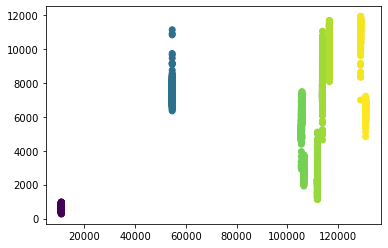

In [88]:
#Exploratory Analysis between Temperature and Power Consumption
import matplotlib.pyplot as plt

#df1 = df[df['Square Feet'] != 421939]
# plt.scatter(df1['Square Feet'], df1['Power Consumption'], c = df1['Square Feet'])

plt.scatter(df['Square Feet'], df['Power Consumption'], c = df['Square Feet'])
plt.show()

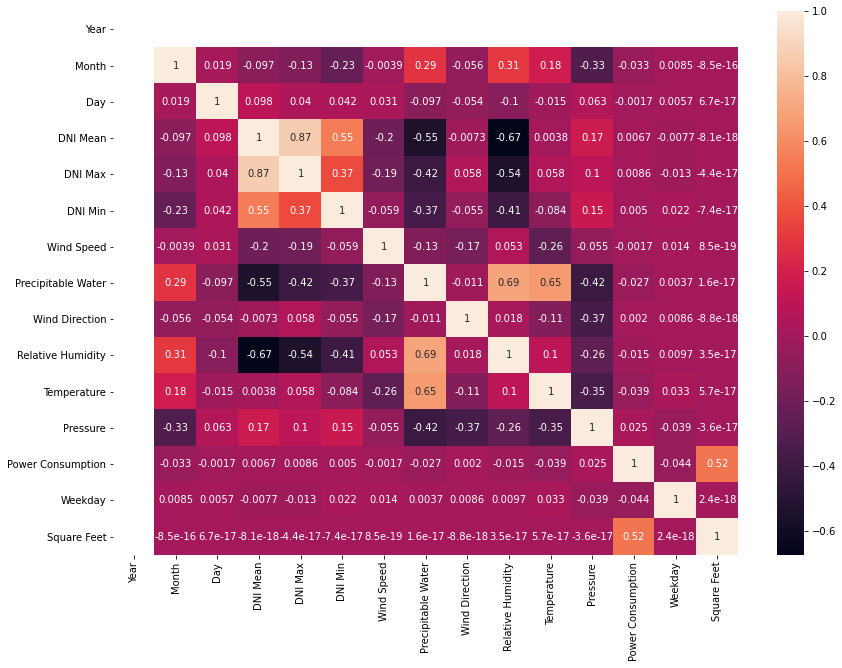

In [87]:
plt.figure(figsize=(14,10))
sns.heatmap(df.corr(), annot=True)
plt.show()

In [89]:
#Saving data to file
df.to_csv('Datasets/UCF_PowerWeatherData.csv', index=False)

In [106]:
df1.head()

,Year,Month,Day,DNI Mean,DNI Max,DNI Min,Wind Speed,Precipitable Water,Wind Direction,Relative Humidity,Temperature,Pressure,Power Consumption,Weekday,University Name,Building Name,Square Feet,Type
0,2019,1,1,576.363636,849,105,1.409091,2.445455,186.636364,71.561818,25.145455,1017.000000,4631.294826,0,University of Central Florida,Harris Corporation Engineering Center,113866,College Building
1,2019,1,1,576.363636,849,105,1.409091,2.445455,186.636364,71.561818,25.145455,1017.000000,6301.517531,0,University of Central Florida,Harris Corporation Engineering Center,113866,College Building
2,2019,1,2,349.636364,848,12,1.372727,2.354545,119.818182,70.552727,24.727273,1017.090909,8303.404328,0,University of Central Florida,Harris Corporation Engineering Center,113866,College Building
3,2019,1,3,262.818182,667,53,2.154545,2.836364,225.000000,73.302727,25.381818,1014.000000,7783.903941,0,University of Central Florida,Harris Corporation Engineering Center,113866,College Building
4,2019,1,4,316.000000,888,3,4.809091,3.118182,206.636364,72.369091,25.300000,1010.272727,7703.588417,0,University of Central Florida,Harris Corporation Engineering Center,113866,College Building


In [116]:
#Merging data
df1 = df
df2 = pd.read_csv('Datasets/UCB_PowerWeatherData.csv')
df_merge = pd.concat([df1, df2], axis=0, join='outer', ignore_index=False, keys=None, levels=None, names=None, verify_integrity=False, copy=True)

df_merge.describe()

,Year,Month,Day,DNI Mean,DNI Max,DNI Min,Wind Speed,Precipitable Water,Wind Direction,Relative Humidity,Temperature,Pressure,Power Consumption,Weekday,Square Feet
count,21910.0,21910.000000,21910.000000,21910.000000,21910.000000,21910.000000,21910.000000,21910.000000,21910.000000,21910.000000,21910.000000,21910.000000,21184.000000,21910.000000,21910.000000
mean,2019.0,6.523505,15.713829,485.868475,773.096303,32.863533,2.683168,1.809916,212.792159,67.055619,17.792555,998.625501,5717.533180,0.284801,110410.486764
std,0.0,3.449163,8.800059,246.848676,263.864163,46.611181,1.140632,1.015242,76.637938,15.971890,5.844183,7.922021,3810.668552,0.451330,71175.521861
min,2019.0,1.000000,1.000000,3.500000,5.000000,1.000000,0.742857,0.286957,15.000000,19.850435,6.516667,979.058824,6.912750,0.000000,10932.000000
25%,2019.0,4.000000,8.000000,280.772727,732.000000,3.000000,1.813333,1.175000,154.400000,58.666333,12.975000,993.500000,2469.000000,0.000000,57714.000000
50%,2019.0,7.000000,16.000000,579.950000,904.000000,14.000000,2.573333,1.564286,241.176471,69.110370,17.220000,996.233333,4863.739736,0.000000,111891.000000
75%,2019.0,10.000000,23.000000,709.809524,940.000000,43.000000,3.337500,2.108333,269.766667,78.701429,21.528000,1002.000000,8958.750000,1.000000,131464.000000
max,2019.0,12.000000,31.000000,832.083333,1032.000000,303.000000,7.200000,6.022222,349.238095,97.390000,33.061538,1024.272727,16745.980000,1.000000,421939.000000


In [122]:
df_merge = df_merge.dropna()

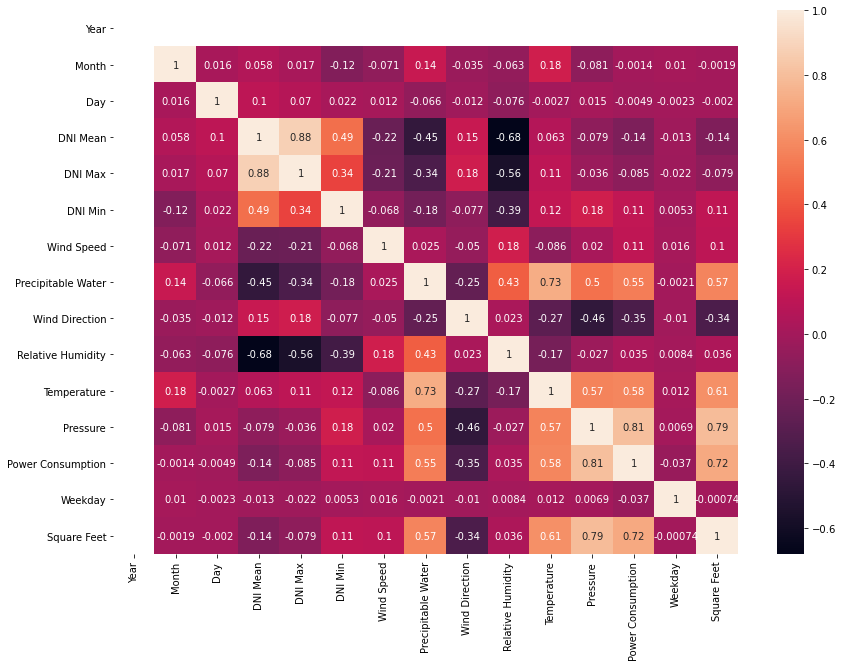

In [123]:
plt.figure(figsize=(14,10))
sns.heatmap(df_merge[df_merge['Type'] == 'College Building'].corr(), annot=True)
plt.show()

In [124]:
df_merge.to_csv('Datasets/Combined_PowerWeatherData.csv', index=False)